In [1]:
from gnnutils import graph, coarsening, utils

import tensorflow as tf
import time, shutil
import numpy as np
import os, collections, sklearn
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [2]:
#Definition of some flags useful later in the code

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', 'data_mnist', 'Directory to store data.')

In [3]:
tf.app.flags.DEFINE_string('f', '', 'kernel')

Layer 0: M_0 = |V| = 1024 nodes (240 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 512 nodes (103 added), |E| = 1448 edges
Layer 2: M_2 = |V| = 256 nodes (38 added), |E| = 691 edges
Layer 3: M_3 = |V| = 128 nodes (10 added), |E| = 346 edges
Layer 4: M_4 = |V| = 64 nodes (0 added), |E| = 172 edges
Execution time: 0.24s


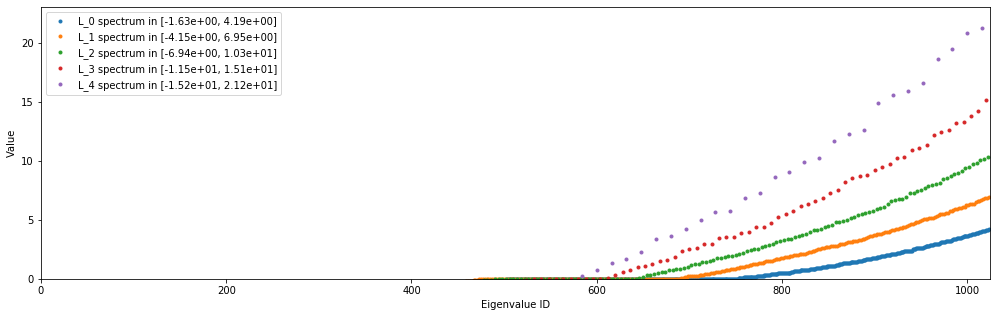

In [4]:
#Here we proceed at computing the original grid where the images live and the various coarsening that are applied
#for each level

def grid_graph(m):
    z = graph.grid(m)  # normalized nodes coordinates
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric) 
    #dist contains the distance of the 8 nearest neighbors for each node indicated in z sorted in ascending order
    #idx contains the indexes of the 8 nearest for each node sorted in ascending order by distance

    A = graph.adjacency(dist, idx)  # graph.adjacency() builds a sparse matrix out of the identified edges computing similarities as: A_{ij} = e^(-dist_{ij}^2/sigma^2)
    
    return A, z

def coarsen(A, nodes_coordinates, levels):
    graphs, parents = coarsening.metis(A, levels) #Coarsen a graph multiple times using Graclus variation of the METIS algorithm. 
                                                  #Basically, we randomly sort the nodes, we iterate on them and we decided to group each node
                                                  #with the neighbor having highest w_ij * 1/(\sum_k w_ik) + w_ij * 1/(\sum_k w_kj) 
                                                  #i.e. highest sum of probabilities to randomly walk from i to j and from j to i.
                                                  #We thus favour strong connections (i.e. the ones with high weight wrt all the others for both nodes) 
                                                  #in the choice of the neighbor of each node.
                    
                                                  #Construction is done a priori, so we have one graph for all the samples!
                    
                                                  #graphs = list of spare adjacency matrices (it contains in position 
                                                  #          0 the original graph)
                                                  #parents = list of numpy arrays (every array in position i contains 
                                                  #           the mapping from graph i to graph i+1, i.e. the idx of
                                                  #           node i in the coarsed graph -> that is, the idx of its cluster) 
    perms = coarsening.compute_perm(parents) #Return a list of indices to reorder the adjacency and data matrices so
                                             #that two consecutive nodes correspond to neighbors that should be collapsed
                                             #to produce the coarsed version of the graph.
                                             #Fake nodes are appended for each node which is not grouped with anybody else
    list_A = []
    coordinates = np.copy(nodes_coordinates)
    
    idx_rows, idx_cols, edge_feat = [], [], []
    for i,A in enumerate(graphs):
        
        M, M = A.shape

        # We remove self-connections created by metis.
        A = A.tocoo()
        A.setdiag(0)

        if i < levels: #if we have to pool the graph 
            A = coarsening.perm_adjacency(A, perms[i]) #matrix A is here extended with the fakes nodes
                                                       #in order to do an efficient pooling operation
                                                       #in tensorflow as it was a 1D pooling
        A = A.tocsr()
        A.eliminate_zeros()
        
        Mnew, Mnew = A.shape
                  
        if i == 0:
            # I add coordinates fake nodes at the beginning and then I simulate a max-pooling operation to coarse them at each layer
            no_fake_node = Mnew-M

            coordinates = [coordinates, np.ones([no_fake_node, 2])*np.inf]
            coordinates = np.concatenate(coordinates, 0)
            coordinates = coordinates[perms[i]]
        
        assert coordinates.shape[0] == coordinates.shape[0]
        
        list_A.append(A)
        
        print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added), |E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))

        c_idx_rows, c_idx_cols = A.nonzero()
        
        c_edge_feat = coordinates[c_idx_rows] - coordinates[c_idx_cols]
        
        assert np.sum(np.isfinite(c_edge_feat.flatten())) == c_edge_feat.shape[0]*c_edge_feat.shape[1]  # check no fake node is an endpoint of an edge 
        idx_rows.append(c_idx_rows)
        idx_cols.append(c_idx_cols)
        edge_feat.append(c_edge_feat)
        
        # update coordinates for next coarser graph
        new_coordinates = []
        for k in range(A.shape[0]//2):
            idx_first_el = k * 2
            
            if not np.isfinite(coordinates[idx_first_el][0]):
                #assert np.isfinite(perm_nodes_coordinates[idx_first_el+1][0])
                new_coordinates.append(coordinates[idx_first_el+1])
            elif not np.isfinite(coordinates[idx_first_el+1][0]):
                #assert np.isfinite(perm_nodes_coordinates[idx_first_el][0])
                new_coordinates.append(coordinates[idx_first_el])
            else:
                new_coordinates.append(np.mean(coordinates[idx_first_el:idx_first_el+2], axis=0))
                
        coordinates = np.asarray(new_coordinates)
    return list_A, perms[0] if len(perms) > 0 else None, idx_rows, idx_cols, edge_feat

t_start = time.time()

np.random.seed(0)
n_rows_cols = 28
A, nodes_coordinates = grid_graph(n_rows_cols)
list_A, perm, idx_rows, idx_cols, edge_feat = coarsen(A, nodes_coordinates, FLAGS.coarsening_levels)

print('Execution time: {:.2f}s'.format(time.time() - t_start))

graph.plot_spectrum(list_A)  
# !!! the plateau is here in correspondence of 1 as here we are plotting the normalized adjacency matrix with self-loops (not the laplacian)!!!

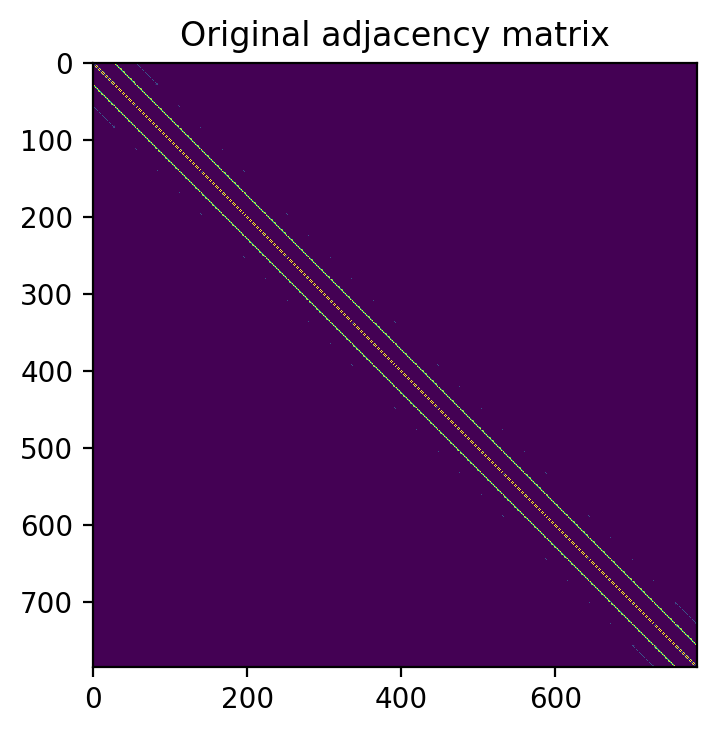

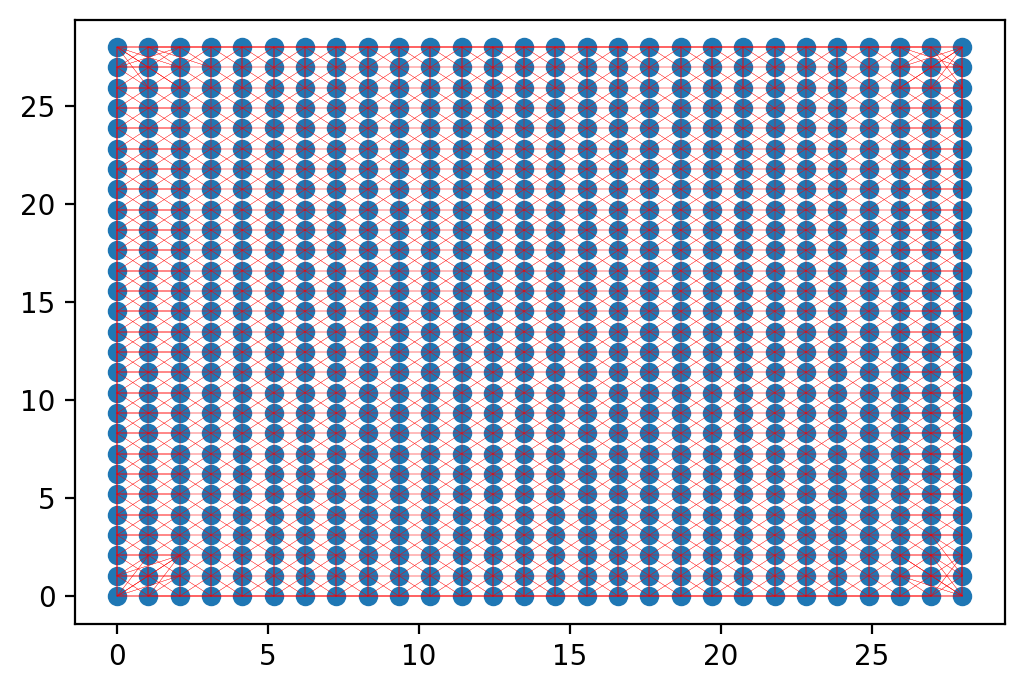

In [6]:
# plot the constructed graph

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def newline(p1, p2):
    # draw a line between p1 and p2
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='r', linewidth=0.1)
    ax.add_line(l)
    return l

plt.figure(dpi=200)
plt.imshow(A.todense())
plt.title('Original adjacency matrix')

plt.figure(dpi=200)
plt.scatter(nodes_coordinates[:, 0]*n_rows_cols, nodes_coordinates[:, 1]*n_rows_cols)

A_row, A_col = A.nonzero()

for idx_e in range(len(A_row)):
    newline(nodes_coordinates[A_row[idx_e]]*n_rows_cols, nodes_coordinates[A_col[idx_e]]*n_rows_cols)

In [7]:
#loading of MNIST dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32) #the first 5K samples of the training dataset 
                                                      #are used for validation
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

t_start = time.time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm

W0821 11:55:08.011470 140496862947136 deprecation.py:323] From <ipython-input-7-8e9e1ea7e7a7>:4: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0821 11:55:08.011913 140496862947136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0821 11:55:08.012262 140496862947136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting data_mnist/train-images-idx3-ubyte.gz
Extracting data_mnist/train-labels-idx1-ubyte.gz
Extracting data_mnist/t10k-images-idx3-ubyte.gz
Extracting data_mnist/t10k-labels-idx1-ubyte.gz
Execution time: 0.86s


In [8]:
class MoNet:
    """
    The neural network model.
    """
    
    #Helper functions used for constructing the model
    def _weight_variable(self, shape, std=0.1, regularization=True): 
        """Initializer for the weights"""
        
        initial = tf.truncated_normal_initializer(0, std)
        var = tf.get_variable('weights', shape, tf.float32, initializer=initial)
        if regularization: #append the loss of the current variable to the regularization term 
            self.regularizers.append(tf.nn.l2_loss(var))
        return var
    
    def _bias_variable(self, shape, regularization=True):
        """Initializer for the bias"""
        
        initial = tf.constant_initializer(0.1)
        var = tf.get_variable('bias', shape, tf.float32, initializer=initial)
        if regularization:
            self.regularizers.append(tf.nn.l2_loss(var))
        return var
    

    def frobenius_norm(self, tensor): 
        """Computes the frobenius norm for a given tensor"""
        
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    def count_no_weights(self):
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            total_parameters += variable_parameters
        print('#weights in the model: %d' % (total_parameters,))
    
    #Modules used by the graph convolutional network
    def MoNet(self, x, idx_rows, idx_cols, edge_feat, A_shape, kernel_std, Fout, K): 
        """Applies chebyshev polynomials over the graph (i.e. it makes a spectral convolution)"""
        
        N, M, Fin = x.get_shape()  # N is the number of images
                                   # M the number of vertices in the images
                                   # Fin the number of features
        N, M, Fin = int(N), int(M), int(Fin)
        
        list_x = [x]
        
        for k in range(K-1):
            with tf.variable_scope('kernel{}'.format(k+1)): 
                mu = tf.get_variable('mean', [1, edge_feat.shape[1]], tf.float32, initializer=tf.random_uniform_initializer(minval=-kernel_std, maxval=kernel_std))
                sigma = tf.get_variable('sigma', [1, edge_feat.shape[1]], tf.float32, initializer=tf.ones_initializer())*kernel_std
                
                kernel_weight = tf.reduce_sum(tf.square(edge_feat - mu)/tf.square(sigma), axis=1)
                
                A_ker = tf.SparseTensor(indices=np.vstack([idx_rows, idx_cols]).T, 
                                        values=kernel_weight, 
                                        dense_shape=A_shape)
                A_ker = tf.sparse_reorder(A_ker)
                A_ker = tf.sparse_softmax(A_ker)
                
            x0 = tf.transpose(x, [1,2,0])  # shape = M x Fin x N
            x0 = tf.reshape(x0, [M, Fin*N])
            x = tf.sparse_tensor_dense_matmul(A_ker, x0)  # shape = M x Fin*N
            x = tf.reshape(x, [M, Fin, N]) # shape = M x Fin x N
            x = tf.transpose(x, [2,0,1])  # shape = N x M x Fin
            
            list_x.append(x)
            
        x = tf.stack(list_x) # shape = K x N x M x Fin
        x = tf.transpose(x, [1,2,3,0]) # shape = N x M x Fin x K
        x = tf.reshape(x, [N*M, Fin*K])  # shape = N*M x Fin*K
        
        # Filter: Fout filters of order K applied over all the Fin features
        W = self._weight_variable([Fin*K, Fout], regularization=False)
        x = tf.matmul(x, W)  # N*M x Fout
        
        return tf.reshape(x, [N, M, Fout])  # N x M x Fout

    def b1relu(self, x):
        """Applies bias and ReLU. One bias per filter."""
        N, M, F = x.get_shape()
        b = self._bias_variable([1, 1, int(F)], regularization=False)
        return tf.nn.relu(x + b) #add the bias to the convolutive layer


    def mpool1(self, x, p):
        """Max pooling of size p. Should be a power of 2 (this is possible thanks to the reordering we previously did)."""
        if p > 1:
            x = tf.expand_dims(x, 3)  # shape = N x M x F x 1
            x = tf.nn.max_pool(x, ksize=[1,p,1,1], strides=[1,p,1,1], padding='SAME')
            return tf.squeeze(x, [3])  # shape = N x M/p x F
        else:
            return x

    def fc(self, x, Mout, relu=True):
        """Fully connected layer with Mout features."""
        N, Min = x.get_shape()
        W = self._weight_variable([int(Min), Mout], regularization=True)
        b = self._bias_variable([Mout], regularization=True)
        x = tf.matmul(x, W) + b
        return tf.nn.relu(x) if relu else x
    
    #function used for extracting the result of our model
    def _inference(self, x, dropout): #definition of the model
        
        # Graph convolutional layers.
        x = tf.expand_dims(x, 2)  # N x M x F=1
        for i in range(len(self.p)):
            with tf.variable_scope('cgconv{}'.format(i+1)):
                with tf.name_scope('filter'):
                    x = self.MoNet(x, self.idx_rows[i*2], self.idx_cols[i*2], self.edge_feat[i*2], self.list_A[i*2].shape, self.list_kernel_std[i*2], self.F[i], self.K[i])
                with tf.name_scope('bias_relu'):
                    x = self.b1relu(x)
                with tf.name_scope('pooling'):
                    x = self.mpool1(x, self.p[i])
        
        # Fully connected hidden layers.
        N, M, F = x.get_shape()
        x = tf.reshape(x, [int(N), int(M*F)])  # N x M
        for i,M in enumerate(self.M[:-1]): #apply a fully connected layer for each layer defined in M
                                           #(we discard the last value in M since it contains the number of classes we have
                                           #to predict)
            with tf.variable_scope('fc{}'.format(i+1)):
                x = self.fc(x, M)
                x = tf.nn.dropout(x, dropout)
        
        # Logits linear layer, i.e. softmax without normalization.
        with tf.variable_scope('logits'):
            x = self.fc(x, self.M[-1], relu=False)
        return x
    
    def convert_coo_to_sparse_tensor(self, L):
        indices = np.column_stack((L.row, L.col))
        L = tf.SparseTensor(indices, L.data.astype('float32'), L.shape)
        L = tf.sparse_reorder(L)
        return L
        
    
    def __init__(self, p, K, F, M, M_0, batch_size, idx_rows, idx_cols, list_A, edge_feat,
                 decay_steps, decay_rate, learning_rate=1e-4, momentum=0.9, regularization=5e-4, 
                 idx_gpu = '/gpu:1'):
        self.regularizers = list() #list of regularization l2 loss for multiple variables
        
        self.p = p #dimensions of the pooling layers
        self.K = K #List of polynomial orders, i.e. filter sizes or number of hops
        self.F = F #Number of features of convolutional layers
        
        self.M = M #Number of neurons in fully connected layers
        
        self.M_0 = M_0 #number of elements in the first graph 
        
        self.batch_size = batch_size
        
        #definition of some learning parameters
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        with tf.Graph().as_default() as g:
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                        #definition of placeholders
                        
                        self.idx_rows = idx_rows
                        self.idx_cols = idx_cols
                        self.edge_feat = edge_feat
                        self.list_A = list_A
                        self.list_kernel_std = [np.mean(np.abs(c_edge_feat.flatten())) for c_edge_feat in edge_feat]
                        self.ph_data = tf.placeholder(tf.float32, (self.batch_size, M_0), 'data')
                        self.ph_labels = tf.placeholder(tf.int32, (self.batch_size), 'labels')
                        self.ph_dropout = tf.placeholder(tf.float32, (), 'dropout')
                    
                        #Model construction
                        self.logits = self._inference(self.ph_data, self.ph_dropout)
                        
                        #Definition of the loss function
                        with tf.name_scope('loss'):
                            self.cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, 
                                                                                                labels=self.ph_labels)
                            self.cross_entropy = tf.reduce_mean(self.cross_entropy)
                        with tf.name_scope('regularization'):
                            self.regularization *= tf.add_n(self.regularizers)
                        self.loss = self.cross_entropy + self.regularization
                        
                        #Solver Definition
                        with tf.name_scope('training'):
                            # Learning rate.
                            global_step = tf.Variable(0, name='global_step', trainable=False) #used for counting how many iterations we have done
                            if decay_rate != 1: #applies an exponential decay of the lr wrt the number of iterations done
                                learning_rate = tf.train.exponential_decay(
                                        learning_rate, global_step, decay_steps, decay_rate, staircase=True)
                            # Optimizer.
                            if momentum == 0:
                                optimizer = tf.train.GradientDescentOptimizer(learning_rate)
                            else: #applies momentum for increasing the robustness of the gradient 
                                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
                            grads = optimizer.compute_gradients(self.loss)
                            self.op_gradients = optimizer.apply_gradients(grads, global_step=global_step) 
                            
                        #Computation of the norm gradients (useful for debugging)
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad], 0))

                        #Extraction of the predictions and computation of accuracy
                        self.predictions = tf.cast(tf.argmax(self.logits, dimension=1), tf.int32)
                        self.accuracy = 100 * tf.contrib.metrics.accuracy(self.predictions, self.ph_labels)
        
                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.global_variables_initializer()
                        self.session.run(init)
                        
                        self.count_no_weights()

In [9]:
#Convolutional parameters
p = [4, 4]   #Dimensions of the pooling layers
K = [25, 25] #List of polynomial orders, i.e. filter sizes or number of hops
F = [32, 64] #Number of features of convolutional layers

#FC parameters
C = max(mnist.train.labels) + 1 #Number of classes we have
M = [512, C] #Number of neurons in fully connected layers

#Solver parameters
batch_size = 100
decay_steps = mnist.train.num_examples / batch_size #number of steps to do before decreasing the learning rate
decay_rate = 0.95 #how much decreasing the learning rate
learning_rate = 0.02
momentum = 0.9
regularization = 5e-4

#Definition of keep probabilities for dropout layers
dropout_training = 0.5
dropout_val_test = 1.0


In [10]:
#Construction of the learning obj
M_0 = list_A[0].shape[0] #number of elements in the first graph
learning_obj = MoNet(p, K, F, M, M_0, batch_size, idx_rows, idx_cols, list_A, edge_feat,
                       decay_steps, decay_rate,
                       learning_rate=learning_rate, regularization=regularization,
                       momentum=momentum)

#definition of overall number of training iterations and validation frequency
num_iter_val = 600
num_total_iter_training = 21000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_val_accuracy = list()

W0821 11:55:14.797573 140496862947136 deprecation.py:506] From <ipython-input-8-c9134dcabb36>:133: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0821 11:55:19.776730 140496862947136 deprecation.py:506] From <ipython-input-8-c9134dcabb36>:215: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


#weights in the model: 2155082


In [11]:
#training and validation
indices = collections.deque() #queue that will contain a permutation of the training indexes
for k in range(num_iter, num_total_iter_training):
    
    #Construction of the training batch
    if len(indices) < batch_size: # Be sure to have used all the samples before using one a second time.
        indices.extend(np.random.permutation(train_data.shape[0])) #reinitialize the queue of indices
    idx = [indices.popleft() for i in range(batch_size)] #extract the current batch of samples
    
    #data extraction
    batch_data, batch_labels = train_data[idx,:], train_labels[idx] 
    
    feed_dict = {learning_obj.ph_data: batch_data, 
                 learning_obj.ph_labels: batch_labels, 
                 learning_obj.ph_dropout: dropout_training}
    
    #Training
    tic = time.time()
    _, current_training_loss, norm_grad = learning_obj.session.run([learning_obj.op_gradients, 
                                                                    learning_obj.loss, 
                                                                    learning_obj.norm_grad], feed_dict = feed_dict) 
    training_time = time.time() - tic
    
    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    
    if (np.mod(num_iter, num_iter_val)==0): #validation
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print(msg)
        
        #Validation Code
        tic = time.time()
        val_accuracy = 0
        for begin in range(0, val_data.shape[0], batch_size):
            end = begin + batch_size
            end = min([end, val_data.shape[0]])
            
            #data extraction
            batch_data = np.zeros((end-begin, val_data.shape[1]))
            batch_data = val_data[begin:end,:]
            batch_labels = np.zeros(batch_size)
            batch_labels[:end-begin] = val_labels[begin:end]
            
            feed_dict = {learning_obj.ph_data: batch_data, 
                         learning_obj.ph_labels: batch_labels,
                         learning_obj.ph_dropout: dropout_val_test}
            
            batch_accuracy = learning_obj.session.run(learning_obj.accuracy, feed_dict)
            val_accuracy += batch_accuracy*batch_data.shape[0]
        val_accuracy = val_accuracy/val_data.shape[0]
        val_time = time.time() - tic
        msg = "[VAL] iter = %03i, acc = %4.2f (%3.2es)" % (num_iter, val_accuracy, val_time)
        print(msg)
    num_iter += 1

[TRN] iter = 000, cost = 1.00e+01, |grad| = 2.69e+01 (3.03e+00s)
[VAL] iter = 000, acc = 11.58 (5.27e+00s)
[TRN] iter = 600, cost = 3.79e+00, |grad| = 1.65e+00 (5.69e-01s)
[VAL] iter = 600, acc = 96.60 (5.31e+00s)
[TRN] iter = 1200, cost = 3.29e+00, |grad| = 7.74e-01 (5.82e-01s)
[VAL] iter = 1200, acc = 97.36 (5.53e+00s)
[TRN] iter = 1800, cost = 3.08e+00, |grad| = 1.38e+00 (5.03e-01s)
[VAL] iter = 1800, acc = 97.94 (4.98e+00s)
[TRN] iter = 2400, cost = 2.77e+00, |grad| = 1.08e+00 (1.70e+00s)
[VAL] iter = 2400, acc = 98.20 (1.74e+01s)
[TRN] iter = 3000, cost = 2.54e+00, |grad| = 1.44e+00 (1.50e+00s)
[VAL] iter = 3000, acc = 98.38 (1.75e+01s)
[TRN] iter = 3600, cost = 2.25e+00, |grad| = 8.35e-01 (1.55e+00s)
[VAL] iter = 3600, acc = 98.42 (1.73e+01s)
[TRN] iter = 4200, cost = 2.06e+00, |grad| = 9.32e-01 (2.02e+00s)
[VAL] iter = 4200, acc = 98.22 (1.74e+01s)
[TRN] iter = 4800, cost = 1.95e+00, |grad| = 8.71e-01 (1.76e+00s)
[VAL] iter = 4800, acc = 98.54 (1.76e+01s)
[TRN] iter = 5400, cost

In [12]:
#Test code
tic = time.time()
test_accuracy = 0
for begin in range(0, test_data.shape[0], batch_size):
    end = begin + batch_size
    end = min([end, test_data.shape[0]])
            
    batch_data = np.zeros((end-begin, test_data.shape[1]))
    batch_data = test_data[begin:end,:]
            
    feed_dict = {learning_obj.ph_data: batch_data, learning_obj.ph_dropout: 1}
            
    batch_labels = np.zeros(batch_size)
    batch_labels[:end-begin] = test_labels[begin:end]
    feed_dict[learning_obj.ph_labels] = batch_labels
            
    batch_accuracy = learning_obj.session.run(learning_obj.accuracy, feed_dict)
    test_accuracy += batch_accuracy*batch_data.shape[0]
test_accuracy = test_accuracy/test_data.shape[0]
test_time = time.time() - tic
msg = "[TST] iter = %03i, acc = %4.2f (%3.2es)" % (num_iter, test_accuracy, test_time)
print(msg)

[TST] iter = 21000, acc = 98.90 (2.91e+01s)


In [ ]:
# 98.24 std=1 _weight_variable